In [1]:
import logging
logging.basicConfig(level=logging.DEBUG)

In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env', verbose=True)

True

In [3]:
import os

BIGQUERY_PROJECT_ID = os.environ.get('BIGQUERY_PROJECT_ID')
BIGQUERY_DATASET = os.environ.get('BIGQUERY_DATASET')
BIGQUERY_DATASET_REGION = os.environ.get('BIGQUERY_DATASET_REGION')
BIGQUERY_TABLE = os.environ.get('BIGQUERY_TABLE')

VERTEXAI_PROJECT_ID = os.environ.get('VERTEXAI_PROJECT_ID')
VERTEXAI_REGION = os.environ.get('VERTEXAI_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BUCKET_URI = os.environ.get('BUCKET_URI')
BUCKET_REGION = os.environ.get('BUCKET_REGION')

PREFIX = os.environ.get('PREFIX')


print("BIGQUERY_PROJECT_ID: ",BIGQUERY_PROJECT_ID)
print("BIGQUERY_DATASET: ",BIGQUERY_DATASET)
print("BIGQUERY_DATASET_REGION: ",BIGQUERY_DATASET_REGION)
print("BIGQUERY_TABLE: ",BIGQUERY_TABLE)

print("VERTEXAI_PROJECT_ID: ",VERTEXAI_PROJECT_ID)
print("VERTEXAI_REGION: ",VERTEXAI_REGION)

print("BUCKET_NAME: ",BUCKET_NAME)
print("BUCKET_URI: ",BUCKET_NAME)
print("BUCKET_REGION: ",VERTEXAI_REGION)

print("PREFIX: ",PREFIX)
PIPELINE_ROOT = 'gs://{}/pipeline_root'.format(BUCKET_NAME)

BIGQUERY_PROJECT_ID:  datafusionsbox
BIGQUERY_DATASET:  dataset4ccc
BIGQUERY_DATASET_REGION:  us
BIGQUERY_TABLE:  df_for_model_ccc_with_weights
VERTEXAI_PROJECT_ID:  datafusionsbox
VERTEXAI_REGION:  us-central1
BUCKET_NAME:  gcp-demo-ccc-vertexai
BUCKET_URI:  gcp-demo-ccc-vertexai
BUCKET_REGION:  us-central1
PREFIX:  ccc


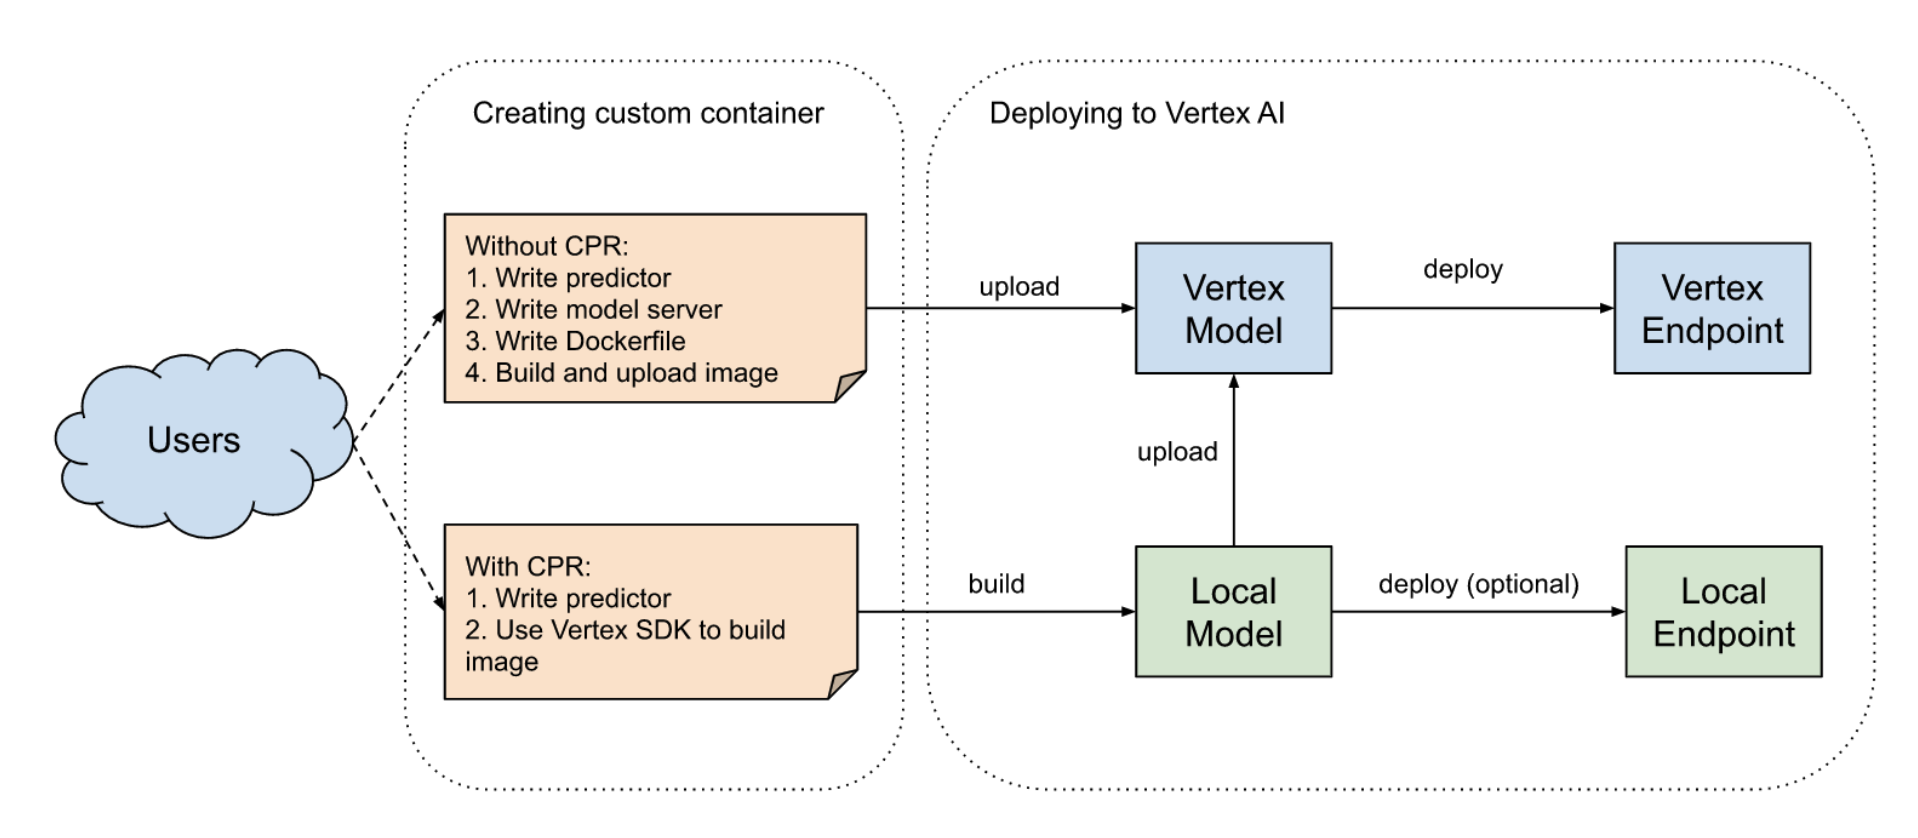  ####### uwaga na data leakage !!!! Weight ===== target
_user_id = "synerise_client_id"
_target_column="y_if_trans"
_weight_column="weight"
_excluded_columns = [_user_id, _target_column, _weight_column]

In [4]:
  ####### uwaga na data leakage !!!! Weight ===== target
_user_id = "synerise_client_id"
_target_column="y_if_trans"
_weight_column="weight"
_excluded_columns = [_user_id, _target_column, _weight_column]

In [5]:
table_id = f"{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"

In [6]:
from google.cloud import bigquery

client = bigquery.Client()
table = client.get_table(table_id)  # Make an API request.

print(
    "Got table '{}.{}.{}'.".format(table.project, table.dataset_id, table.table_id)
)

DEBUG:google.auth._default:Checking None for explicit credentials as part of auth process...
DEBUG:google.auth._default:Checking Cloud SDK credentials as part of auth process...
DEBUG:google.auth._default:Cloud SDK credentials not found on disk; not using them
DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
DEBUG:google.auth._default:Checking None for explicit credentials as part of auth process...
DEBUG:google.auth._default:Checking Cloud SDK credentials as part of auth process...
DEBUG:google.auth._default:Cloud SDK credentials not found on disk; not using them
DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
DEBUG:google.cloud.bigquery.opentelemetry_tracin

Got table 'datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights'.


In [7]:
_features = []
for schema_field in table.schema:
    if schema_field.name not in _excluded_columns:
        _features.append(schema_field.name)

#### Zalozmy ze eksperymentujemy sobie lokalnie z trenowaniem modelu

In [119]:
import tensorflow as tf

In [120]:
_METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=32, activation = "relu"))
model.add(tf.keras.layers.Dense(units=32,activation="relu")) 
model.add(tf.keras.layers.Dropout(rate=0.25))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
        

model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=tf.keras.losses.BinaryCrossentropy(), 
            metrics=_METRICS,
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [121]:
weight_for_0 = 0.5 ##(1 / neg) * (total / 2.0)
weight_for_1 = 20 ##(1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 20.00


In [122]:
### tutaj zakladam ze przeklikane jest cwiczenie 3a
import pandas as pd
gcs_output_training_dataset=f"{PIPELINE_ROOT}/staging/{PREFIX}_training.csv"
gcs_output_validation_dataset=f"{PIPELINE_ROOT}/staging/{PREFIX}_validation.csv"
gcs_output_testing_dataset=f"{PIPELINE_ROOT}/staging/{PREFIX}_testing.csv"

training_dataset = pd.read_csv(gcs_output_training_dataset)
validation_dataset = pd.read_csv(gcs_output_validation_dataset)
test_dataset = pd.read_csv(gcs_output_testing_dataset)


x_train = training_dataset[_features]
y_train = training_dataset[_target_column]

x_val = validation_dataset[_features]
y_val = validation_dataset[_target_column]

x_test = test_dataset[_features]
y_test = test_dataset[_target_column]

In [127]:
output = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val) , callbacks=[stop_early], class_weight=class_weights)

Epoch 1/10
   24/26025 [..............................] - ETA: 57s - loss: 0.6475 - tp: 13.0000 - fp: 195.0000 - tn: 550.0000 - fn: 10.0000 - accuracy: 0.7331 - precision: 0.0625 - recall: 0.5652 - auc: 0.7466 - prc: 0.0741                     

2023-02-22 16:16:37.666031: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 446378656 exceeds 10% of free system memory.


26025/26025 [==============================] - 64s 2ms/step - loss: 0.5758 - tp: 14072.0000 - fp: 258742.0000 - tn: 554138.0000 - fn: 5844.0000 - accuracy: 0.6823 - precision: 0.0516 - recall: 0.7066 - auc: 0.7554 - prc: 0.0798 - val_loss: 0.5834 - val_tp: 3568.0000 - val_fp: 65223.0000 - val_tn: 137985.0000 - val_fn: 1424.0000 - val_accuracy: 0.6799 - val_precision: 0.0519 - val_recall: 0.7147 - val_auc: 0.7656 - val_prc: 0.0861
Epoch 2/10
26025/26025 [==============================] - 66s 3ms/step - loss: 0.5756 - tp: 14075.0000 - fp: 257574.0000 - tn: 555306.0000 - fn: 5841.0000 - accuracy: 0.6837 - precision: 0.0518 - recall: 0.7067 - auc: 0.7559 - prc: 0.0793 - val_loss: 0.5566 - val_tp: 3457.0000 - val_fp: 60014.0000 - val_tn: 143194.0000 - val_fn: 1535.0000 - val_accuracy: 0.7044 - val_precision: 0.0545 - val_recall: 0.6925 - val_auc: 0.7618 - val_prc: 0.0856
Epoch 3/10
26025/26025 [==============================] - 63s 2ms/step - loss: 0.5736 - tp: 14126.0000 - fp: 255428.0000 

In [13]:
CUSTOM_CODE_DIR=f"{PREFIX}_cpredictor"
CUSTOM_MODEL_ARTIFACTS="model_artifacts"

In [13]:
%mkdir $CUSTOM_CODE_DIR $CUSTOM_CODE_DIR/$CUSTOM_MODEL_ARTIFACTS

mkdir: cannot create directory ‘ccc_cpredictor’: File exists
mkdir: cannot create directory ‘ccc_cpredictor/model_artifacts’: File exists


In [14]:
model_path=f"{CUSTOM_CODE_DIR}/{CUSTOM_MODEL_ARTIFACTS}"
model.save(model_path)

NameError: name 'model' is not defined

#### Masz model - teraz chcialbys zobaczyc jak on sie zachowuje jako REST API zanim wyslesz go do veretx AI

In [14]:
from google.cloud.aiplatform.prediction.predictor import Predictor
from google.cloud.aiplatform.utils import prediction_utils

In [15]:
FEATURESTORE_ID=f"{PREFIX}_promotions"

In [111]:
script = f"""import joblib
import pickle
import numpy as np
import json

from google.cloud.aiplatform.prediction.predictor import Predictor
from google.cloud.aiplatform.utils import prediction_utils
import tensorflow as tf
from google.cloud import aiplatform
from google.cloud.aiplatform import Featurestore
import numpy as np

class CustomPredictor(Predictor):
    def __init__(self):
        return
    
    def load(self, artifacts_uri: str):
        fs = Featurestore(
           featurestore_name=\"{FEATURESTORE_ID}\",
           project=\"{VERTEXAI_PROJECT_ID}\",
           location=\"{VERTEXAI_REGION}\",
        )

        self._stats_entity_type = fs.get_entity_type(entity_type_id="stats")
        self._model = tf.keras.models.load_model('model_artifacts')
    
    ##def preprocess(self, prediction_input: Any):
        
    def predict(self, instances):
        user_ids = instances["instances"]
        print("user ids",user_ids)
        instance_ids=list(np.concatenate(user_ids))
        instances = self._stats_entity_type.read(entity_ids=instance_ids) ##get all features , feature_ids=_features)
        inputs = instances.drop("entity_id", axis=1)
        pinputs = inputs.values.tolist()

        outputs = self._model.predict(pinputs)
        print(outputs)
        return outputs.tolist()
        
    def postprocess(self, prediction_results: list):
        return {{ "predictions": prediction_results }}
    """

In [112]:
filename=f"./{CUSTOM_CODE_DIR}/predictor.py" 

In [113]:
import os
with open(filename, "w") as f:
    f.write(script)
    f.close()

In [114]:
%%writefile $CUSTOM_CODE_DIR/requirements.txt
fastapi
uvicorn==0.17.6
numpy~=1.20
joblib~=1.0
tensorflow
google-cloud-storage>=1.26.0,<2.0.0dev
google-cloud-aiplatform[prediction]>=1.16.0
pandas

Overwriting ccc_cpredictor/requirements.txt


### Build Local Vertex AI Endpoint

In [115]:
import os

from google.cloud.aiplatform.prediction import LocalModel
from ccc_cpredictor.predictor import CustomPredictor

In [116]:
_MY_ARTIFACTORY_REPOSITORY_NAME = f"{PREFIX}-repository"  
_MY_CUSTOM_DOCKER_IMAGE_NAME = f"{PREFIX}-promo-image" 

In [117]:
requirements_path=os.path.join(CUSTOM_CODE_DIR, "requirements.txt")
requirements_path

'ccc_cpredictor/requirements.txt'

In [118]:
local_root=f"/home/jupyter/{PREFIX}"

In [119]:
%cd $local_root

/home/jupyter/ccc


In [127]:
local_model = LocalModel.build_cpr_model(
    CUSTOM_CODE_DIR,
    f"{VERTEXAI_REGION}-docker.pkg.dev/{VERTEXAI_PROJECT_ID}/{_MY_ARTIFACTORY_REPOSITORY_NAME}/{_MY_CUSTOM_DOCKER_IMAGE_NAME}",
    predictor=CustomPredictor,
    requirements_path=os.path.join(CUSTOM_CODE_DIR, "requirements.txt"),
)

INFO:google.cloud.aiplatform.docker_utils.build:Running command: docker build -t us-central1-docker.pkg.dev/datafusionsbox/ccc-repository/ccc-promo-image --rm -f- ccc_cpredictor
INFO:google.cloud.aiplatform.docker_utils.local_util:Sending build context to Docker daemon  199.2kB
INFO:google.cloud.aiplatform.docker_utils.local_util:

INFO:google.cloud.aiplatform.docker_utils.local_util:Step 1/14 : FROM python:3.7

INFO:google.cloud.aiplatform.docker_utils.local_util: ---> d76fe8c4018b

INFO:google.cloud.aiplatform.docker_utils.local_util:Step 2/14 : ENV PYTHONDONTWRITEBYTECODE=1

INFO:google.cloud.aiplatform.docker_utils.local_util: ---> Using cache

INFO:google.cloud.aiplatform.docker_utils.local_util: ---> 40c54cebcf80

INFO:google.cloud.aiplatform.docker_utils.local_util:Step 3/14 : EXPOSE 8080

INFO:google.cloud.aiplatform.docker_utils.local_util: ---> Using cache

INFO:google.cloud.aiplatform.docker_utils.local_util: ---> 7ffd03939b59

INFO:google.cloud.aiplatform.docker_utils.local

In [121]:
local_model = LocalModel(
    serving_container_image_uri=f"{VERTEXAI_REGION}-docker.pkg.dev/{VERTEXAI_PROJECT_ID}/{_MY_ARTIFACTORY_REPOSITORY_NAME}/{_MY_CUSTOM_DOCKER_IMAGE_NAME}",
    serving_container_predict_route="/predict",
    serving_container_health_route="/health",
)

In [122]:
local_model.get_serving_container_spec()

image_uri: "us-central1-docker.pkg.dev/datafusionsbox/ccc-repository/ccc-promo-image"
predict_route: "/predict"
health_route: "/health"

In [137]:
INPUT_FILE = "instances.json"

In [124]:
%%writefile instances.json
{
    "instances": [
        ["3692184251"], ["2374580415"], ["4549777227"], ["1684193966"], ["4757806082"]
    ]
}

Overwriting instances.json


In [125]:
import logging
logging.basicConfig(level=logging.DEBUG)

## Deploy to Local Endpoint

In [128]:
with local_model.deploy_to_local_endpoint(
    artifact_uri=f"{CUSTOM_CODE_DIR}/{CUSTOM_MODEL_ARTIFACTS}",
) as local_endpoint:
    predict_response = local_endpoint.predict(
        request_file=INPUT_FILE,
        headers={"Content-Type": "application/json"},
    )

DEBUG:google.auth._default:Checking None for explicit credentials as part of auth process...
DEBUG:google.auth._default:Checking Cloud SDK credentials as part of auth process...
DEBUG:google.auth._default:Cloud SDK credentials not found on disk; not using them
DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
INFO:google.cloud.aiplatform.prediction.local_endpoint:Got the project id from the global config: datafusionsbox.
DEBUG:docker.utils.config:Trying paths: ['/home/jupyter/.docker/config.json', '/home/jupyter/.dockercfg']
DEBUG:docker.utils.config:Found file at path: /home/jupyter/.docker/config.json
DEBUG:docker.auth:Found 'credHelpers' section
DEBUG:urllib3.connectionpool:http://localhost:None "GET /version HTTP/1.1" 200 842
DEBUG:urllib3.connectionpool:http://localhost:None "POST /v1.40/containers/create HTTP/1.1" 201

In [129]:
print(predict_response, predict_response.content)

<Response [200]> b'{"predictions": [[0.18076057732105255], [0.017141303047537804], [0.1759321242570877], [0.18466457724571228], [0.9999996423721313]]}'


In [130]:
local_endpoint.print_container_logs(show_all=True)

DEBUG:urllib3.connectionpool:http://localhost:None "GET /v1.40/containers/6310efd00f070a9e896a7429639723245bd3844d3ab7f6e766625eac61bf02dd/logs?stderr=1&stdout=1&timestamps=0&follow=0&tail=all HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:http://localhost:None "GET /v1.40/containers/6310efd00f070a9e896a7429639723245bd3844d3ab7f6e766625eac61bf02dd/json HTTP/1.1" 200 None
INFO:google.cloud.aiplatform.docker_utils.run:WARNING:root:Set the number of model server workers to 4.
INFO:google.cloud.aiplatform.docker_utils.run:INFO:     Uvicorn running on http://0.0.0.0:8080 (Press CTRL+C to quit)
INFO:google.cloud.aiplatform.docker_utils.run:INFO:uvicorn.error:Uvicorn running on http://0.0.0.0:8080 (Press CTRL+C to quit)
INFO:google.cloud.aiplatform.docker_utils.run:INFO:     Started parent process [1]
INFO:google.cloud.aiplatform.docker_utils.run:INFO:uvicorn.error:Started parent process [1]
INFO:google.cloud.aiplatform.docker_utils.run:2023-02-22 19:16:54.559857: I tensorflow/core/platform/

### Zalozmy ze jestemy OK z naszym modelem i customowym predyktorem. Wrzucmy nasz dockerowy obraz do Artifactory

In [131]:
!gcloud services enable artifactregistry.googleapis.com



To take a quick anonymous survey, run:
  $ gcloud survey



In [132]:
!gcloud artifacts repositories create {_MY_ARTIFACTORY_REPOSITORY_NAME} \
    --repository-format=docker \
    --location={VERTEXAI_REGION}

Create request issued for: [ccc-repository]
Waiting for operation [projects/datafusionsbox/locations/us-central1/operations
/1101bb0b-9523-46dc-8d41-5a9793c9d108] to complete...done.                     
Created repository [ccc-repository].


In [133]:
!gcloud auth configure-docker {VERTEXAI_REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-west1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
Docker configuration file updated.


In [134]:
## Use SDk to push the image
local_model.push_image()

INFO:google.cloud.aiplatform.docker_utils.local_util:Using default tag: latest

INFO:google.cloud.aiplatform.docker_utils.local_util:The push refers to repository [us-central1-docker.pkg.dev/datafusionsbox/ccc-repository/ccc-promo-image]

INFO:google.cloud.aiplatform.docker_utils.local_util:bc334b75d0e8: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:1ae670027636: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:b0d9f81db332: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:5a54800c08fb: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:4169ad63f09d: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:b2cc056dd71d: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:2167aebfcb85: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:17efc79ac0fe: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:0b6859e9fff1: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:11829b

### Wrzucamy nasz model na GCS

In [135]:
%cd $CUSTOM_CODE_DIR
!gsutil rsync -d -r {CUSTOM_MODEL_ARTIFACTS}/ {PIPELINE_ROOT}/{CUSTOM_MODEL_ARTIFACTS}/
!gsutil ls {PIPELINE_ROOT}/{CUSTOM_MODEL_ARTIFACTS}/*

/home/jupyter/ccc/ccc_cpredictor
Building synchronization state...
Starting synchronization...
Copying file://model_artifacts/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://model_artifacts/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://model_artifacts/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://model_artifacts/variables/variables.index [Content-Type=application/octet-stream]...
- [4 files][180.7 KiB/180.7 KiB]                                                
Operation completed over 4 objects/180.7 KiB.                                    
gs://gcp-demo-ccc-vertexai/pipeline_root/model_artifacts/keras_metadata.pb
gs://gcp-demo-ccc-vertexai/pipeline_root/model_artifacts/saved_model.pb

gs://gcp-demo-ccc-vertexai/pipeline_root/model_artifacts/variables/:
gs://gcp-demo-ccc-vertexai/pipeline_root/model_artifacts/variables/variables.data-00000-of-00001
gs://gcp-demo-ccc-vertexai/pipeli

### Postawmy local endpoint ale z modelu z GCS zeby upewnic sie ze na GCS mamy to czego bysmy oczekiwali

In [139]:
%cd $local_root

/home/jupyter/ccc


In [140]:
with local_model.deploy_to_local_endpoint(
    artifact_uri=f"{PIPELINE_ROOT}/{CUSTOM_MODEL_ARTIFACTS}",
    ##credential_path=CREDENTIALS_FILE,
) as local_endpoint:
    predict_response = local_endpoint.predict(
        request_file=INPUT_FILE,
        headers={"Content-Type": "application/json"},
    )

DEBUG:google.auth._default:Checking None for explicit credentials as part of auth process...
DEBUG:google.auth._default:Checking Cloud SDK credentials as part of auth process...
DEBUG:google.auth._default:Cloud SDK credentials not found on disk; not using them
DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
INFO:google.cloud.aiplatform.prediction.local_endpoint:Got the project id from the global config: datafusionsbox.
DEBUG:docker.utils.config:Trying paths: ['/home/jupyter/.docker/config.json', '/home/jupyter/.dockercfg']
DEBUG:docker.utils.config:Found file at path: /home/jupyter/.docker/config.json
DEBUG:docker.auth:Found 'credHelpers' section
DEBUG:urllib3.connectionpool:http://localhost:None "GET /version HTTP/1.1" 200 842
DEBUG:urllib3.connectionpool:http://localhost:None "POST /v1.40/containers/create HTTP/1.1" 201

In [141]:
print(predict_response, predict_response.content)

<Response [200]> b'{"predictions": [[0.08053020387887955], [0.206941157579422], [0.08128506690263748], [0.15781211853027344], [5.4541693828014104e-08]]}'


### Zarejestrujmy model w Vertex AI Model registry

In [142]:
from google.cloud import aiplatform

In [143]:
aiplatform.init(project=VERTEXAI_PROJECT_ID, location=VERTEXAI_REGION)

In [146]:
model = aiplatform.Model.upload(
    local_model=local_model,
    display_name=f"{PREFIX}_model_exc36_cpr",
    artifact_uri=f"{PIPELINE_ROOT}/{CUSTOM_MODEL_ARTIFACTS}",
)

DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): metadata.google.internal:80
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/default/?recursive=true HTTP/1.1" 200 193
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/339239659

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/339239659794/locations/us-central1/models/2524217013606285312/operations/4542151597416775680


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/339239659794/locations/us-central1/models/2524217013606285312/operations/4542151597416775680
DEBUG:google.api_core.retry:Retrying due to , sleeping 0.7s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 1.6s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 1.8s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 10.3s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 3.6s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 42.3s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 60.0s ...
DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
DEBUG:urllib

Model created. Resource name: projects/339239659794/locations/us-central1/models/2524217013606285312@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/339239659794/locations/us-central1/models/2524217013606285312@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/339239659794/locations/us-central1/models/2524217013606285312@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/339239659794/locations/us-central1/models/2524217013606285312@1')


In [149]:
endpoint_labels = {
         "experiment_name": f"{PREFIX}-experiments-cpr"
}

endpoint_name = f"{PREFIX}_endpoint_exc6_cpr"

endpoint = aiplatform.Endpoint.create(
          display_name = endpoint_name,
          labels = endpoint_labels   
        )

DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): metadata.google.internal:80
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/default/?recursive=true HTTP/1.1" 200 193
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/339239659

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/339239659794/locations/us-central1/endpoints/1764834909836279808/operations/5665377491980648448


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/339239659794/locations/us-central1/endpoints/1764834909836279808/operations/5665377491980648448
DEBUG:google.api_core.retry:Retrying due to , sleeping 1.3s ...


Endpoint created. Resource name: projects/339239659794/locations/us-central1/endpoints/1764834909836279808


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/339239659794/locations/us-central1/endpoints/1764834909836279808


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/339239659794/locations/us-central1/endpoints/1764834909836279808')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/339239659794/locations/us-central1/endpoints/1764834909836279808')
DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id


In [152]:
endpoint.deploy(
    model = model,
    machine_type="n1-standard-4",
    service_account="339239659794-compute@developer.gserviceaccount.com"
)

Deploying Model projects/339239659794/locations/us-central1/models/2524217013606285312 to Endpoint : projects/339239659794/locations/us-central1/endpoints/1764834909836279808


INFO:google.cloud.aiplatform.models:Deploying Model projects/339239659794/locations/us-central1/models/2524217013606285312 to Endpoint : projects/339239659794/locations/us-central1/endpoints/1764834909836279808
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): metadata.google.internal:80
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/default/?recursive=true HTTP/1.1" 200 193
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/339239659794-

Deploy Endpoint model backing LRO: projects/339239659794/locations/us-central1/endpoints/1764834909836279808/operations/3041327021595557888


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/339239659794/locations/us-central1/endpoints/1764834909836279808/operations/3041327021595557888
DEBUG:google.api_core.retry:Retrying due to , sleeping 1.9s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 3.4s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 4.4s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 2.8s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 13.4s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 46.6s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 60.0s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 60.0s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 60.0s ...
DEBUG:google.api_core.retry:Retrying due to , sleeping 60.0s ...


Endpoint model deployed. Resource name: projects/339239659794/locations/us-central1/endpoints/1764834909836279808


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/339239659794/locations/us-central1/endpoints/1764834909836279808
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): metadata.google.internal:80
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/default/?recursive=true HTTP/1.1" 200 193
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2

In [153]:
result = endpoint.predict(instances=[['3692184251'], ['2374580415'], ['4549777227'], ['1684193966'], ['4757806082']])
result

DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): metadata.google.internal:80
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/default/?recursive=true HTTP/1.1" 200 193
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform HTTP/1.1" 200 1083


Prediction(predictions=[[0.0873262882232666], [0.006880779284983873], [0.1012144759297371], [0.1846645772457123], [0.0]], deployed_model_id='7811840999348502528', model_version_id='1', model_resource_name='projects/339239659794/locations/us-central1/models/2524217013606285312', explanations=None)

In [156]:
import gradio as gr
import requests
from google.cloud import aiplatform
from google.cloud.aiplatform import Feature, Featurestore


endpoint_filter_str='labels.experiment_name="'+f"{PREFIX}-experiments-cpr"+'"'

endpoints = aiplatform.Endpoint.list(
       filter=endpoint_filter_str,
)
endpoint = endpoints[0]


def greet(in_threshold, in_user_id):
    threshold = in_threshold
    user_id = in_user_id

    
    #### Make call to vertex AI Endpoint
    result = endpoint.predict(instances=[[user_id]])
    print(result)
    classification_result = False
    if result.predictions[0][0] > threshold:
        classification_result = True
    return classification_result, result.predictions[0], result.deployed_model_id, result.model_version_id, result.model_resource_name

    
gInputs = [gr.Slider(0, 1, label = 'classification threshold', value = 0.5),
           gr.Textbox(label = 'synerise_client_id', value = '3129545367')
          ]

##Prediction(predictions=[[0.00370752811]], deployed_model_id='2233288435920011264', 
##model_version_id='3', model_resource_name='projects/339239659794/locations/us-central1/models/1047599285782183936', explanations=None
gOutputs = [gr.Textbox(label="Result"),
            gr.Textbox(label="Prediction"),
            gr.Textbox(label="Response: deployed model ID"),
            gr.Textbox(label="Response: model version ID"),
            gr.Textbox(label="Response: model resource name")
           ]

demo = gr.Interface(fn=greet, inputs=gInputs, outputs=gOutputs, allow_flagging='never')

demo.launch(share=True) 

DEBUG:google.auth.transport._http_client:Making request: GET http://169.254.169.254
DEBUG:google.auth.transport._http_client:Making request: GET http://metadata.google.internal/computeMetadata/v1/project/project-id
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): metadata.google.internal:80
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/default/?recursive=true HTTP/1.1" 200 193
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/339239659

Running on local URL:  http://127.0.0.1:7863


DEBUG:urllib3.connectionpool:https://api.gradio.app:443 "GET /v2/tunnel-request HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): 77970c95-f90d-45f3.gradio.live:443
DEBUG:urllib3.connectionpool:https://77970c95-f90d-45f3.gradio.live:443 "HEAD / HTTP/1.1" 200 0


Running on public URL: https://77970c95-f90d-45f3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.gradio.app:443


DEBUG:urllib3.connectionpool:https://api.gradio.app:443 "POST /gradio-launched-analytics/ HTTP/1.1" 200 None
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): metadata.google.internal:80
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/default/?recursive=true HTTP/1.1" 200 193
DEBUG:google.auth.transport.requests:Making request: GET http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform
DEBUG:urllib3.connectionpool:http://metadata.google.internal:80 "GET /computeMetadata/v1/instance/service-accounts/339239659794-compute@developer.gserviceaccount.com/token?scopes=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-pla

Prediction(predictions=[[3.747384600855107e-19]], deployed_model_id='7811840999348502528', model_version_id='1', model_resource_name='projects/339239659794/locations/us-central1/models/2524217013606285312', explanations=None)
